In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive
from var import fname2mname, network2pair, network_sort_key

In [2]:
method_l = [
    "maxcorr", 
    "mincorr", 
    # "maxlinreg", 
    # "minlinreg", 
    # "cca", 
    # "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/attn_results4_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["maxcorr"]["corrs"]]

num_heads_d = {}
for network in network_l:
    num_heads_d[network] = len(next(iter(res_d["maxcorr"]["corrs"][network].values()))) # god this is a hack

# DataFrames

In [4]:
maxcorr_df = pd.DataFrame(res_d["maxcorr"]["similarities"])
maxcorr_df = maxcorr_df.reindex(maxcorr_df.columns)

In [5]:
mincorr_df = pd.DataFrame(res_d["mincorr"]["similarities"])
mincorr_df = mincorr_df.reindex(mincorr_df.columns)

# Heatmaps

In [6]:
plt.rcParams["figure.figsize"] = (20,15)

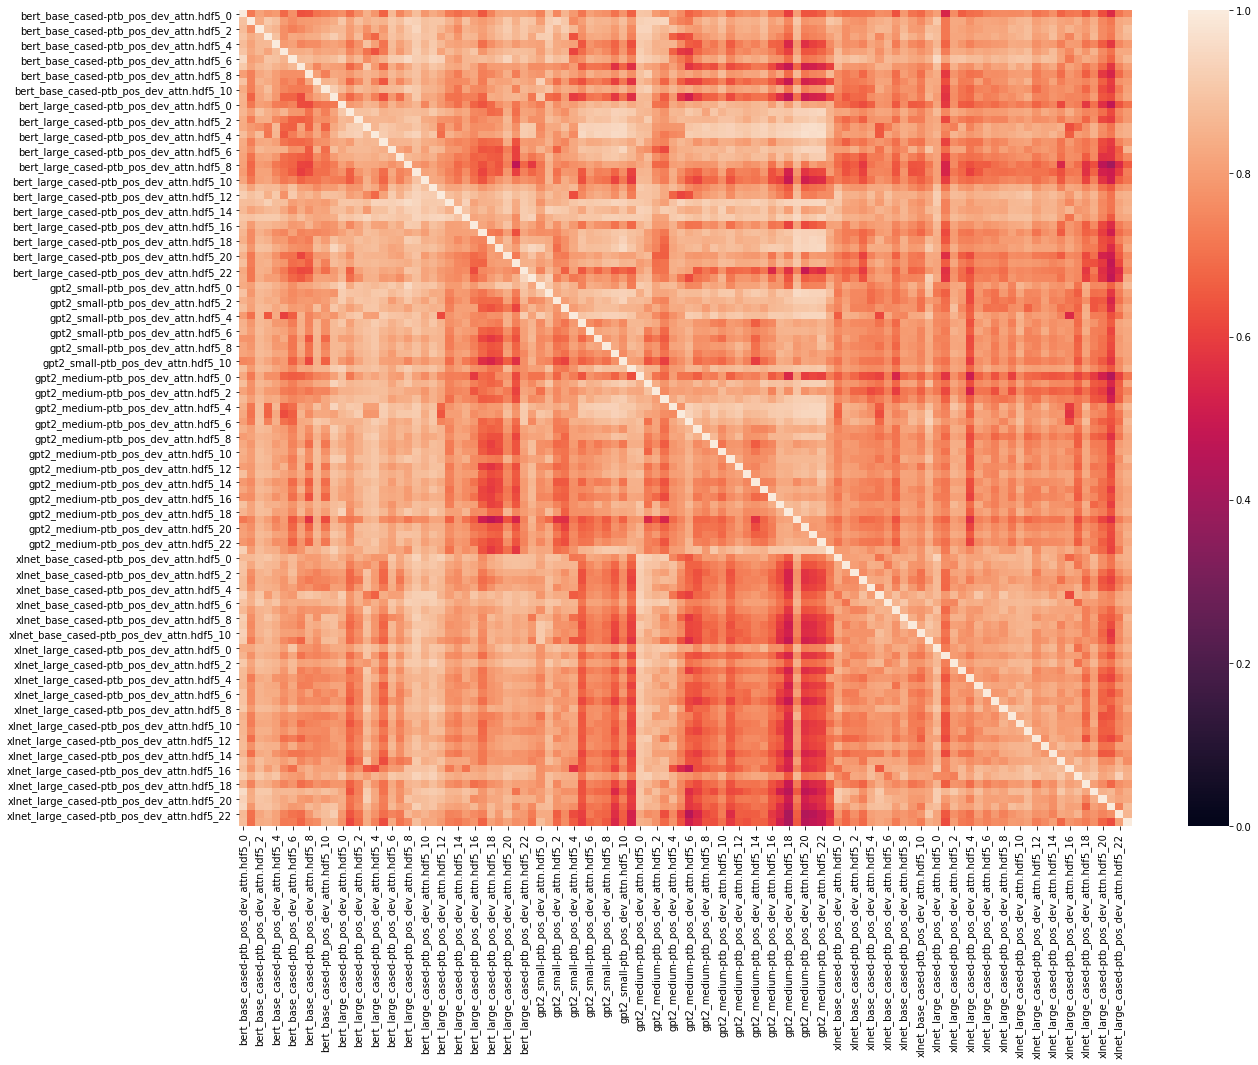

In [7]:
sns.heatmap(maxcorr_df.fillna(1), vmin=0, vmax=1)

In [10]:
torch.norm?

In [8]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [9]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_maxmincorr_attn_8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.2)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0, step=0.2), Output()), _dom_classes=('w…